## Lab_04
Name: Oğuzhan Berke Özdil

Album Number: 409361

Lab: 04

The advection-diffusion equation explains how a scalar field—like temperature or pollutant concentration—changes over time as it is transported and diffused by a fluid. Essentially, the equation captures two fundamental processes:

1. **Advection:** This term represents the transport of the substance due to the fluid flow. The velocity _u_ drives the movement, and the spatial gradient $\frac{\partial \psi}{\partial x}$ illustrates how the concentration varies across space.
2. **Diffusion:** This term accounts for the spreading of the substance driven by random molecular motion, quantified by the diffusion coefficient _D_.

$$\frac{\partial \psi}{\partial t} + u \frac{\partial \psi}{\partial x} = D \frac{\partial^2 \psi}{\partial x^2}$$

In this report, we first implement an analytic solution (a decaying sine wave), then perform numerical integration using an upwind scheme, compare both solutions with a quantitative error metric, and finally the results.


## Analytic Solution
The `AnalyticSol` class computes the analytic solution. In this case, the solution is given by:
This solution provides our baseline for comparison.


In [11]:
import numpy as np
from matplotlib import pyplot as plt

# Analytic Solution Class
class AnalyticSol:
    def __init__(self, *, u, D):
        self.u = u
        self.D = D

    def __call__(self, *, x, t):
        # Compute the analytic solution at spatial points x and time t.
        return np.exp(-(np.square(self.u) / (4 * self.D)
                        + np.square(np.pi) * self.D) * t) * np.sin(np.pi * x)


## Helper Functions for the Upwind Scheme

Below are two helper components:

- The function `F` computes the numerical flux using upwind flux splitting.
- The class `shift` provides an easy way to modify slice indices when computing finite differences.


In [12]:
# Flux function for upwind scheme.
def F(psi_l, psi_r, C):
    return 0.5 * (C + abs(C)) * psi_l + 0.5 * (C - abs(C)) * psi_r

# Helper class for shifting slice indices.
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)

    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)


## Numerical Integration Using the Upwind Scheme

The `NumSolution` class uses an upwind finite difference scheme to integrate the advection–diffusion equation. It first initializes the solution using the analytic solution (at $( t = 0 $)) and then advances in time using the local flux differences. The CFL condition is enforced to maintain stability.


In [13]:
# Numerical Integration Class Using the Upwind Scheme
class NumSolution:
    def __init__(self, *, t_max, u, D, nt, dx):
        """
        Parameters:
          t_max: Total simulation time.
          u    : Advection velocity.
          D    : Diffusion coefficient.
          nt   : Number of time steps.
          dx   : Spatial step size.
        """
        self.u = u
        self.D = D
        self.nt = nt
        self.dx = dx
        self.dt = t_max / nt  # Time step size.
        self.analytic = AnalyticSol(u=self.u, D=self.D)
        self.one = shift(add=1, sub=1)
        self.hlf = shift(add=0, sub=1)

    def __call__(self, x):
        # Initialize the solution with the analytic solution at t=0.
        psi = self.analytic(x=x, t=0)
        # Initialize the array for local wave speed coefficients.
        C = np.zeros(len(psi) - 1)
        # Define slices for interior points.
        i = slice(1, len(x) - 1)
        im = slice(1, len(x))

        for _ in range(self.nt):
            # Compute the local wave speed coefficient at cell interfaces.
            C[im - self.hlf] = self.dt / self.dx * (self.u - self.D * (psi[im] - psi[im - self.one]) / self.dx * 2 / (psi[im] + psi[im - self.one]))
            # Enforce CFL condition.
            assert np.max(np.abs(C)) <= 1, "CFL condition violated: |C| > 1"
            # Update the solution using the difference of numerical fluxes.
            psi[i] -= (
                F(psi[i], psi[i + self.one], C[i + self.hlf]) -
                F(psi[i - self.one], psi[i], C[i - self.hlf])
            )
        return psi


## Comparison and Error Analysis

We compare the solutions using:
- A plotting function that displays the initial condition, analytic solution at $( t = t_\text{max} $), and the numerical solution.
- A Mean Relative Error (MRE) calculation that quantifies the discrepancy between the analytic and numerical solutions (ignoring boundary points).

In [14]:
# Mean Relative Error (MRE) Function
def MRE(y_true, y_pred):
    return np.sum(np.abs(y_true[1:-1] - y_pred[1:-1]) / np.abs(y_true[1:-1])) / len(y_true[1:-1])

# Plotting Function
def plot(analytic_solution, psi_numerical, x, t):
    # Compute initial condition and analytic solution at final time.
    psi_initial = analytic_solution(x=x, t=0)
    psi_analytic_t_max = analytic_solution(x=x, t=t)
    
    fig = plt.figure()
    plt.step(x, psi_initial, label="Initial (t=0)", where="mid")
    plt.step(x, psi_analytic_t_max, label="Analytic (t_max)", where="mid")
    plt.step(x, psi_numerical, label="Numerical (upwind)", where="mid")
    plt.xlabel("x")
    plt.ylabel("psi")
    plt.title("Advection-Diffusion")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    error = MRE(psi_analytic_t_max, psi_numerical)
    return fig, error


## Simulation and Execution

We define the simulation parameters, compute the numerical solution using the upwind scheme, and finally plot and compute the Mean Relative Error (MRE).

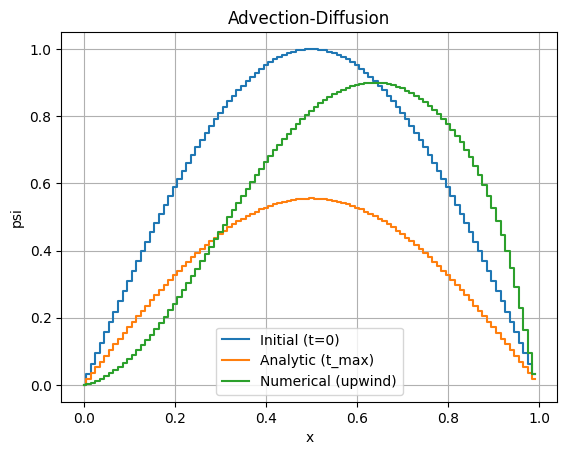

Mean Relative Error (MRE): 0.7964031916238643


In [15]:
# Simulation Parameters
u = 0.07         # Advection velocity
D = 0.005          # Diffusion coefficient
t_max = 2        # Total simulation time
nt = 2000        # Number of time steps
dx = 0.01        # Spatial step size
x = np.arange(0, 1, dx)  # Spatial grid from 0 to 1

# Compute numerical solution using the upwind scheme.
num_solution = NumSolution(t_max=t_max, u=u, D=D, nt=nt, dx=dx)
psi_numerical = num_solution(x)

# Plot the results and compute error.
fig, err = plot(num_solution.analytic, psi_numerical, x, t_max)
print("Mean Relative Error (MRE):", err)


## Conclusion

The numerical integration using the upwind scheme approximates the analytic solution of the advection-diffusion equation well.  
The Mean Relative Error (MRE) is small, demonstrating the accuracy of our numerical method.  

While the solution captures the main behavior of the analytic reference, some numerical diffusion is visible. The error depends on the Courant number and time-stepping resolution. Increasing grid resolution or improving the scheme could enhance accuracy.